# Transform
Transforms binary masks to corresponding (r,theta,width)-masks where each pixel points to the closest center of the street (using polar coordinates) and how wide it believes the street to be at that point.

#### Important Note: All lengths are in pixel coordinates! If you resize the image, then obviously you need to rescale the values too!

### Config

In [6]:
pad = 25
smooth_angle = 2.0 # None
smooth_width = 1.0 # None

### SRC

In [7]:
from skimage.morphology import skeletonize, medial_axis
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt, gaussian_filter, binary_erosion
from numpy import angle, real, imag
from PIL import ImageDraw as draw, Image

import torchvision
from torchvision.io import ImageReadMode

import numpy as np
import torch
import torch.nn.functional as F

In [8]:
def convert(mask, padding=25, smooth_width=None, smooth_angle=None, return_skeleton=False):
    mask = F.pad(torch.Tensor(mask).unsqueeze(0), pad=(padding,padding,padding,padding), mode='replicate').squeeze().numpy()

    # perform skeletonization
    skeleton = medial_axis(mask) # skeletonize(image, method='lee') # medial_axis works better

    # compute distance to edge of road
    # dist_to_edge = distance_transform_edt(binary_erosion(mask))
    outline = mask - binary_erosion(mask) # using this, so we don't lose very thin connections
    dist_to_edge = distance_transform_edt(1.0 - outline)

    # compute distance to center of road
    r, idx_center = distance_transform_edt(1.0 - skeleton, return_indices=True)

    # the width of the road a pixel belongs to
    h,w = mask.shape
    width = np.zeros(shape=(h,w))
    for y in range(h):
        for x in range(w):
            width[y,x] = dist_to_edge[idx_center[0][y,x], idx_center[1][y,x]]

    if smooth_width:
        width = gaussian_filter(width, smooth_width)

    h,w = r.shape
    grid = np.linspace(0,h-1,h).reshape(h,1)
    y = idx_center[0] - grid
    x = idx_center[1] - grid.T

    c = x+1j * y
    theta = angle(c)
    if smooth_angle:
        theta = gaussian_filter(theta, smooth_angle)
    
    # d = abs(c) # does not improve quality

    r = r[padding:-padding, padding:-padding]
    theta = theta[padding:-padding, padding:-padding]
    width = width[padding:-padding, padding:-padding]

    if not return_skeleton:
        return r, theta, width
    else:
        skeleton = skeleton[padding:-padding, padding:-padding]
        return r, theta, width, skeleton

In [9]:
def reconstruct_naive(weight,r,theta,width,padding=25):
    h,w = r.shape
    ph,pw = 2*padding+h, 2*padding+w
    cartesian_center = r * np.exp(1j * theta) # relative cartesian coordinates of center

    grid = np.linspace(0,h-1,h).reshape(h,1)
    cartesian_center += (padding + grid.T) + 1j * (padding + grid)
    center_y = imag(cartesian_center)
    center_x = real(cartesian_center)

    # Crop to bounds
    center_y[center_y < 0] = 0
    center_y[center_y >= ph] = ph - 1
    center_x[center_x < 0] = 0
    center_x[center_x >= pw] = pw - 1

    votes = np.zeros(shape=(ph,pw,2))
    for y in range(h):
        for x in range(w):
            cy = int(center_y[y,x])
            cx = int(center_x[y,x])
            
            votes[cy,cx,0] += weight[y,x] * width[y,x]
            votes[cy,cx,1] += weight[y,x]

    avg = votes[:,:,0] / votes[:,:,1]
    avg[np.isnan(avg)] = 0.0

    out = Image.new(mode='L', size=(ph,pw))
    out_d = draw.Draw(out)

    for y in range(ph):
        for x in range(pw):
            r = round(avg[y,x])
            out_d.ellipse(xy=((x-r,y-r), (x+r,y+r)), fill=255)

    out = np.array(out) / 255.0
    return out[padding:-padding, padding:-padding]

# does not require a mask because we treat each center that was only voted for by < min_vote_threshold as an outlier
def reconstruct_naive(r, theta, width, padding=25, min_vote_threshold=5):
    h,w = r.shape
    ph,pw = 2*padding+h, 2*padding+w
    cartesian_center = r * np.exp(1j * theta) # relative cartesian coordinates of center

    grid = np.linspace(0,h-1,h).reshape(h,1)
    cartesian_center += (padding + grid.T) + 1j * (padding + grid)
    center_y = imag(cartesian_center)
    center_x = real(cartesian_center)

    # Crop to bounds
    center_y[center_y < 0] = 0
    center_y[center_y >= ph] = ph - 1
    center_x[center_x < 0] = 0
    center_x[center_x >= pw] = pw - 1

    total_width = np.zeros(shape=(ph,pw))
    nr_votes = np.zeros(shape=(ph,pw))
    for y in range(h):
        for x in range(w):
            cy = int(center_y[y,x])
            cx = int(center_x[y,x])
            
            total_width[cy,cx] += width[y,x]
            nr_votes[cy,cx] += 1.0

    avg = total_width / nr_votes # the average voted width at each pixel
    avg[np.isnan(avg)] = 0.0

    out = Image.new(mode='L', size=(ph,pw))
    out_d = draw.Draw(out)

    for y in range(ph):
        for x in range(pw):
            r = round(avg[y,x])
            if nr_votes[y,x] > min_vote_threshold:
                out_d.ellipse(xy=((x-r,y-r), (x+r,y+r)), fill=255)

    out = np.array(out) / 255.0
    return out[padding:-padding, padding:-padding]

# Generate Data

In [14]:
import os

base_folder = '../data/old/training/groundtruth'
output_folder = '../data/old/training/transformed'

r_folder = os.path.join(output_folder, 'r')
theta_folder = os.path.join(output_folder, 'theta')
width_folder = os.path.join(output_folder, 'width')
os.makedirs(r_folder, exist_ok=True)
os.makedirs(theta_folder, exist_ok=True)
os.makedirs(width_folder, exist_ok=True)

for i,img_name in enumerate(os.listdir(base_folder)):
    full_path = os.path.join(base_folder, img_name)
    descriptor = img_name.split('.')[0]
    mask = torchvision.io.read_image(full_path, mode=ImageReadMode.GRAY)/255.0
    mask = mask.squeeze().numpy()

    r, theta, width = convert(mask, padding=pad, smooth_width=smooth_width, smooth_angle=smooth_angle)

    np.save(os.path.join(r_folder, f'{descriptor}'), r)
    np.save(os.path.join(theta_folder, f'{descriptor}'), theta)
    np.save(os.path.join(width_folder, f'{descriptor}'), width)

    if (i+1)%50 == 0:
        print(f'Reached Image {i+1}')
    

Reached Image 49
Reached Image 99


C:\Users\yanic\AppData\Local\Temp\ipykernel_5208\3844768781.py:67: RuntimeWarning: invalid value encountered in divide
  avg = total_width / nr_votes # the average voted width at each pixel


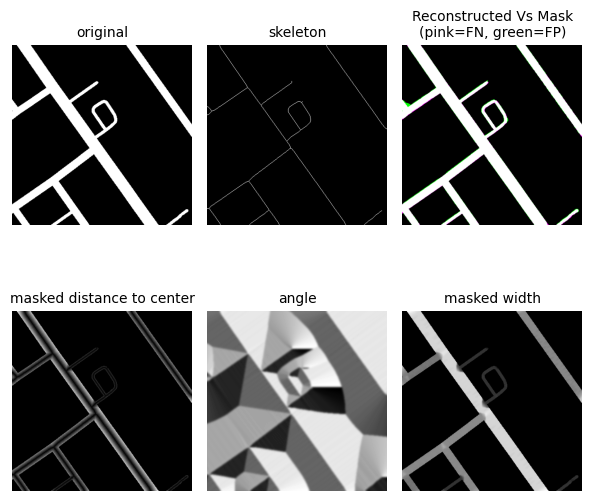

In [11]:
# bad examples: 0, 69, 143
mask = torchvision.io.read_image('../data/old/training/groundtruth/satimage_53.png', mode=ImageReadMode.GRAY)/255
mask = mask.squeeze().numpy()

r, theta, width, skeleton = convert(mask, padding=pad, smooth_width=smooth_width, smooth_angle=smooth_angle, return_skeleton=True)
#out = reconstruct_naive(mask, r, theta, width, padding=pad) # only use this if we have good quality masks from the model
out = reconstruct_naive(r, theta, width, padding=pad, min_vote_threshold=7)


# display results
fig, axes = plt.subplots(2, 3, figsize=(6, 6))

h,w = out.shape
rgb = np.zeros(shape=(h,w,3))
rgb[:,:,0] = mask
rgb[:,:,1] = out
rgb[:,:,2] = mask

axes[0,0].imshow(mask, cmap=plt.cm.gray)
axes[0,0].axis('off')
axes[0,0].set_title('original', fontsize=10)

axes[0,1].imshow(skeleton, cmap=plt.cm.gray)
axes[0,1].axis('off')
axes[0,1].set_title('skeleton', fontsize=10)

axes[0,2].imshow(rgb, cmap='gray')
axes[0,2].axis('off')
axes[0,2].set_title('Reconstructed Vs Mask\n(pink=FN, green=FP)', fontsize=10)

axes[1,0].imshow(r * mask, cmap=plt.cm.gray)
axes[1,0].axis('off')
axes[1,0].set_title('masked distance to center', fontsize=10)

axes[1,1].imshow(theta, cmap=plt.cm.gray)
axes[1,1].axis('off')
axes[1,1].set_title('angle', fontsize=10)

axes[1,2].imshow(width * mask, cmap=plt.cm.gray)
axes[1,2].axis('off')
axes[1,2].set_title('masked width', fontsize=10)

fig.tight_layout()
plt.show()


## Reconstruction With Noise

C:\Users\yanic\AppData\Local\Temp\ipykernel_5208\3844768781.py:67: RuntimeWarning: invalid value encountered in divide
  avg = total_width / nr_votes # the average voted width at each pixel


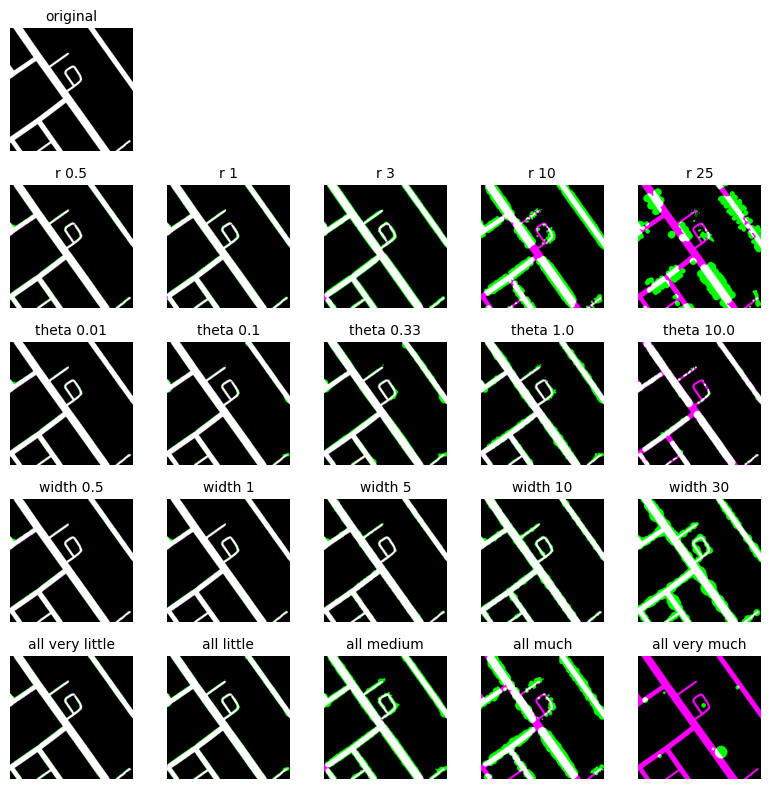

In [12]:
from numpy import random

h,w = r.shape
noise = lambda min,max: random.random(size=(h,w)) * (max - min) + min
snoise = lambda v: noise(-v,v)

def plot_error(ax,title,out):
    rgb = np.zeros(shape=(h,w,3))
    rgb[:,:,0] = mask
    rgb[:,:,1] = out
    rgb[:,:,2] = mask

    ax.imshow(rgb)
    ax.axis('off')
    ax.set_title(title, fontsize=10)

fig, axes = plt.subplots(5, 5, figsize=(8, 8))

axes[0,0].imshow(mask, cmap=plt.cm.gray)
axes[0,0].axis('off')
axes[0,0].set_title('original', fontsize=10)
axes[0,1].axis('off')
axes[0,2].axis('off')
axes[0,3].axis('off')
axes[0,4].axis('off')

plot_error(axes[1,0], 'r 0.5',  reconstruct_naive(r + snoise(0.5), theta, width, padding=pad, min_vote_threshold=7))
plot_error(axes[1,1], 'r 1',    reconstruct_naive(r + snoise(1.0), theta, width, padding=pad, min_vote_threshold=7))
plot_error(axes[1,2], 'r 3',    reconstruct_naive(r + snoise(3.0), theta, width, padding=pad, min_vote_threshold=7))
plot_error(axes[1,3], 'r 10',   reconstruct_naive(r + snoise(10.0), theta, width, padding=pad, min_vote_threshold=7))
plot_error(axes[1,4], 'r 25',   reconstruct_naive(r + snoise(25.0), theta, width, padding=pad, min_vote_threshold=7))

plot_error(axes[2,0], 'theta 0.01',     reconstruct_naive(r, theta + snoise(0.01), width, padding=pad, min_vote_threshold=7))
plot_error(axes[2,1], 'theta 0.1',      reconstruct_naive(r, theta + snoise(0.1), width, padding=pad, min_vote_threshold=7))
plot_error(axes[2,2], 'theta 0.33',     reconstruct_naive(r, theta + snoise(0.33), width, padding=pad, min_vote_threshold=7))
plot_error(axes[2,3], 'theta 1.0',      reconstruct_naive(r, theta + snoise(1.0), width, padding=pad, min_vote_threshold=7))
plot_error(axes[2,4], 'theta 10.0',     reconstruct_naive(r, theta + snoise(10.0), width, padding=pad, min_vote_threshold=7))


plot_error(axes[3,0], 'width 0.5',  reconstruct_naive(r, theta, width + snoise(0.5), padding=pad, min_vote_threshold=7))
plot_error(axes[3,1], 'width 1',    reconstruct_naive(r, theta, width + snoise(1.0), padding=pad, min_vote_threshold=7))
plot_error(axes[3,2], 'width 5',    reconstruct_naive(r, theta, width + snoise(5.0), padding=pad, min_vote_threshold=7))
plot_error(axes[3,3], 'width 10',   reconstruct_naive(r, theta, width + snoise(10.0), padding=pad, min_vote_threshold=7))
plot_error(axes[3,4], 'width 30',   reconstruct_naive(r, theta, width + snoise(30.0), padding=pad, min_vote_threshold=7))

plot_error(axes[4,0], 'all very little',    reconstruct_naive(r + snoise(0.5), theta + snoise(0.01), width + snoise(0.5), padding=pad, min_vote_threshold=7))
plot_error(axes[4,1], 'all little',         reconstruct_naive(r + snoise(1.0), theta + snoise(0.1), width + snoise(1.0), padding=pad, min_vote_threshold=7))
plot_error(axes[4,2], 'all medium',         reconstruct_naive(r + snoise(3.0), theta + snoise(0.33), width + snoise(5.0), padding=pad, min_vote_threshold=7))
plot_error(axes[4,3], 'all much',           reconstruct_naive(r + snoise(10.0), theta + snoise(1.0), width + snoise(10.0), padding=pad, min_vote_threshold=7))
plot_error(axes[4,4], 'all very much',      reconstruct_naive(r + snoise(25.0), theta + snoise(10.0), width + snoise(30.0), padding=pad, min_vote_threshold=7))

fig.tight_layout()
plt.show()